<a href="https://colab.research.google.com/github/strawndri/ic-drug-repurposing/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Importações

## 1.1 Bibliotecas

- [Pandas](https://pandas.pydata.org/): manipulação e análise de dados;
- [NetworkX](https://networkx.org/): criação, manipulação e visualização de grafos e redes complexas;
- [iGraph](https://python.igraph.org/en/stable/): análise e manipulação de grafos;
- [Graph Tools](https://pypi.org/project/graph-tools/): manipulação e análise de grafos.

In [2]:
pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from igraph import *

## 1.2 Bases de dados

In [4]:
ppi = pd.read_csv("https://raw.githubusercontent.com/strawndri/ic-drug-repurposing/refs/heads/main/data/PPI.csv")
ppi.head()

,from,to,Source
0,A1BG,ABCC6,HINT|PINA|APID|BioGrid|Instruct
1,A1BG,ANXA7,HINT|HIPPIE|PINA|APID|BioGrid|Instruct|MINT
2,A1BG,CDKN1A,Signalink|HINT|PINA|APID|BioGrid|Instruct|MINT
3,A1BG,CRISP3,PINA|InWeb
4,A1BG,FDXR,BioPlex


In [5]:
ppi_human_virus = pd.read_csv('https://raw.githubusercontent.com/strawndri/ic-drug-repurposing/refs/heads/main/data/HVIDB_PPIs.csv')
ppi_human_virus.head()

,Uniprot_human,Uniprot_virus,EntryName_human,EntryName_virus,Organism_human,Organism_virus,Organism_Interactor_human,Organism_Interactor_virus,Experimental_System,Pubmed_ID,...,Short,HDF,HRF,Viral_family,Human_GeneName,Human_ProteinName,Human_GeneID,Virus_GeneName,Virus_ProteinName,Virus_GeneID
0,P62277,Q1HVI8,RS13_HUMAN,EBNA5_EBVA8,Homo sapiens (Human),Epstein-Barr virus (strain AG876) (HHV-4) (Hum...,9606,82830,two hybrid,22761553,...,HHV-4,no,no,Herpesviridae,RPS13,40S ribosomal protein S13,6207,EBNA-LP;EBNA5,Epstein-Barr nuclear antigen leader protein,5176191
1,Q8NFH4,P05954,NUP37_HUMAN,VPR_HV1RH,Homo sapiens (Human),Human immunodeficiency virus type 1 group M su...,9606,11701,Reactome Curated,21067998,...,HIV-1,no,no,Retroviridae,NUP37,Nucleoporin Nup37,79023,vpr,Protein Vpr,NaN
2,Q9UI26,Q2HRD4,IPO11_HUMAN,ORF4_HHV8P,Homo sapiens (Human),Human herpesvirus 8 type P (isolate GK18) (HHV...,9606,868565,affinity chromatography technology,25544563,...,HHV-8P,no,no,Herpesviridae,IPO11;RANBP11,Importin-11,51194,ORF4,Complement control protein,4961488
3,Q8TAE8,I6TAH8,G45IP_HUMAN,I6TAH8_I68A0,Homo sapiens (Human),Influenza A virus (strain A/Aichi/2/1968 H3N2),9606,387139,anti tag coimmunoprecipitation,28169297,...,H3N2,no,no,Orthomyxoviridae,GADD45GIP1;MRPL59;PLINP1;PRG6,Growth arrest and DNA damage-inducible protein...,90480,NP,Nucleoprotein,NaN
4,Q7Z3B4,P35962,NUP54_HUMAN,GAG_HV1Y2,Homo sapiens (Human),Human immunodeficiency virus type 1 group M su...,9606,362651,Reactome Curated,21067998,...,HIV-1,no,no,Retroviridae,NUP54,Nucleoporin p54,53371,gag,Gag polyprotein,NaN


In [6]:
dictionary = pd.read_csv("https://raw.githubusercontent.com/strawndri/ic-drug-repurposing/refs/heads/main/data/gene_dictionary.txt")
dictionary.head()

,Symbol,Category_cl
0,A1BG,Protein Coding
1,A1BG-AS1,lncRNA
2,A1CF,Protein Coding
3,A2M,Protein Coding
4,A2M-AS1,lncRNA


# 2 Funções

In [92]:
def plot_gene_protein_graph(ppi_data, proteins, genes, title, sizeX, sizeY):
  g = Graph(directed=False)

  # vértices
  human_genes = ppi_data[genes].unique()
  viral_proteins = ppi_data[proteins].str.split(';').explode().unique()

  g.add_vertices(len(human_genes) + len(viral_proteins))

  g.vs['name'] = list(human_genes) + list(viral_proteins)
  g.vs['type'] = ['human'] * len(human_genes) + ['viral'] * len(viral_proteins)

  name_to_index = {name: index for index, name in enumerate(g.vs['name'])}

  # arestas
  for _, row in ppi_data.iterrows():
      human_gene = row[genes]
      viral_proteins = row[proteins].split(';')

      for protein in viral_proteins:
          protein_name = protein.strip()
          if protein_name in name_to_index:
              g.add_edge(name_to_index[human_gene], name_to_index[protein_name])

  # rótulos e cores (vértices)
  g.vs['label'] = g.vs['name']
  color_dict = {'human': '#c2d1faf5', 'viral': '#ff1657f5'}
  g.vs['color'] = [color_dict[v_type] for v_type in g.vs['type']]
  g.vs['size'] = [30 if v_type == 'viral' else 20 for v_type in g.vs['type']]

  # rótulos e cores (arestas)
  g.es['color'] = "#7a7a7a"
  g.es['width'] = 0.8

  layout = g.layout('fr')

  # plotar o grafo
  plt.figure(figsize=(sizeX, sizeY))
  plot(g, layout=layout, bbox=(1000, 800), margin=10, target=plt.gca(),
       edge_width=g.es['width'], edge_color=g.es['color'])
  plt.title(title)
  plt.show()

In [8]:
def calculate_lcc(graph):
    # encontra todos os componentes conectados
    components = nx.connected_components(graph)
    # calcula o tamanho do maior componente conectado
    lcc_size = max(len(component) for component in components)
    return lcc_size

In [9]:
# gera grafos aleatórios para comparar
def generate_random_graphs(num_graphs, num_nodes, prob):
    return [nx.erdos_renyi_graph(num_nodes, prob) for _ in range(num_graphs)]

In [10]:
def plot_histogram(lcc_random, lcc, title, label):
    plt.figure(figsize=(10, 6))
    plt.hist(lcc_random, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

    plt.axvline(lcc, color='red', linestyle='dashed', linewidth=2, label=label)

    plt.title(title)
    plt.xlabel('Tamanho do LCC')
    plt.ylabel('Frequência')
    plt.legend()
    plt.grid(True)
    plt.show()

# 3 Tratamento e seleção de dados

In [11]:
ppi_human_virus = ppi_human_virus.rename(columns={"Human_GeneName" : "Human_GeneSymbol"})

In [12]:
ppi_human_virus['Human_GeneSymbol'] = ppi_human_virus['Human_GeneSymbol'].str.split(';').str[0]

## 3.1 HVI-1 (cepa/grupo M, subtipo D)

In [13]:
selecao = (ppi_human_virus['Short'] == 'HIV-1') & (ppi_human_virus['Organism_virus'].str.contains('group M subtype D', na=False))
ppi_hiv1MD = ppi_human_virus[selecao]

In [14]:
ppi_hiv1MD['Experimental_System'].str.split(',').explode().value_counts().head(50)

,count
Experimental_System,
Reactome Curated,1275
two hybrid*,17
pull down,4
x-ray crystallography,1


In [15]:
ppi_hiv1MD['Interaction_Type'].value_counts()

,count
Interaction_Type,
physical association,1297


In [16]:
ppi_hiv1MD.reset_index(inplace=True)
ppi_hiv1MD = ppi_hiv1MD[['Uniprot_human', 'Uniprot_virus', 'Human_GeneSymbol']]

ppi_hiv1MD

,Uniprot_human,Uniprot_virus,Human_GeneSymbol
0,Q10567,P04604,AP1B1
1,Q92621,P04592,NUP205
2,P18074,P12511,ERCC2
3,Q92556,P12478,ELMO1
4,P13010,P05925,XRCC5
...,...,...,...
1296,Q9BW27,P05925,NUP85
1297,P01903,P12495,HLA-DRA
1298,P27487,P12506,DPP4
1299,P01889,P12499,HLA-B


## 3.2 HVI-2 (cepa/subgrupo A)

In [17]:
selecao = (ppi_human_virus['Short'] == 'HIV-2') & (ppi_human_virus['Organism_virus'].str.contains('subtype A', na=False))
ppi_hiv2A = ppi_human_virus[selecao]

In [18]:
ppi_hiv2A['Experimental_System'].str.split(',').explode().value_counts()

,count
Experimental_System,
two hybrid,13
affinity chromatography technology,7
gst pull down,7
pull down,4
coimmunoprecipitation,3
Other Methods,3
anti tag coimmunoprecipitation,3
two hybrid*,2
protein kinase assay,1


In [19]:
ppi_hiv2A['Interaction_Type'].str.split(',').explode().value_counts()

,count
Interaction_Type,
physical association,32
direct interaction,5
phosphorylation reaction,1


In [20]:
ppi_hiv2A.reset_index(inplace=True)
ppi_hiv2A = ppi_hiv2A[['Uniprot_human', 'Uniprot_virus', 'Human_GeneSymbol']]

ppi_hiv2A.head()

,Uniprot_human,Uniprot_virus,Human_GeneSymbol
0,P20963,P18092,CD247
1,Q99816,P04590,TSG101
2,Q13501,P18094,SQSTM1
3,Q99816,P18095,TSG101
4,O43172,P18095,PRPF4


# 4 Análise de interações entre proteínas virais e humanas

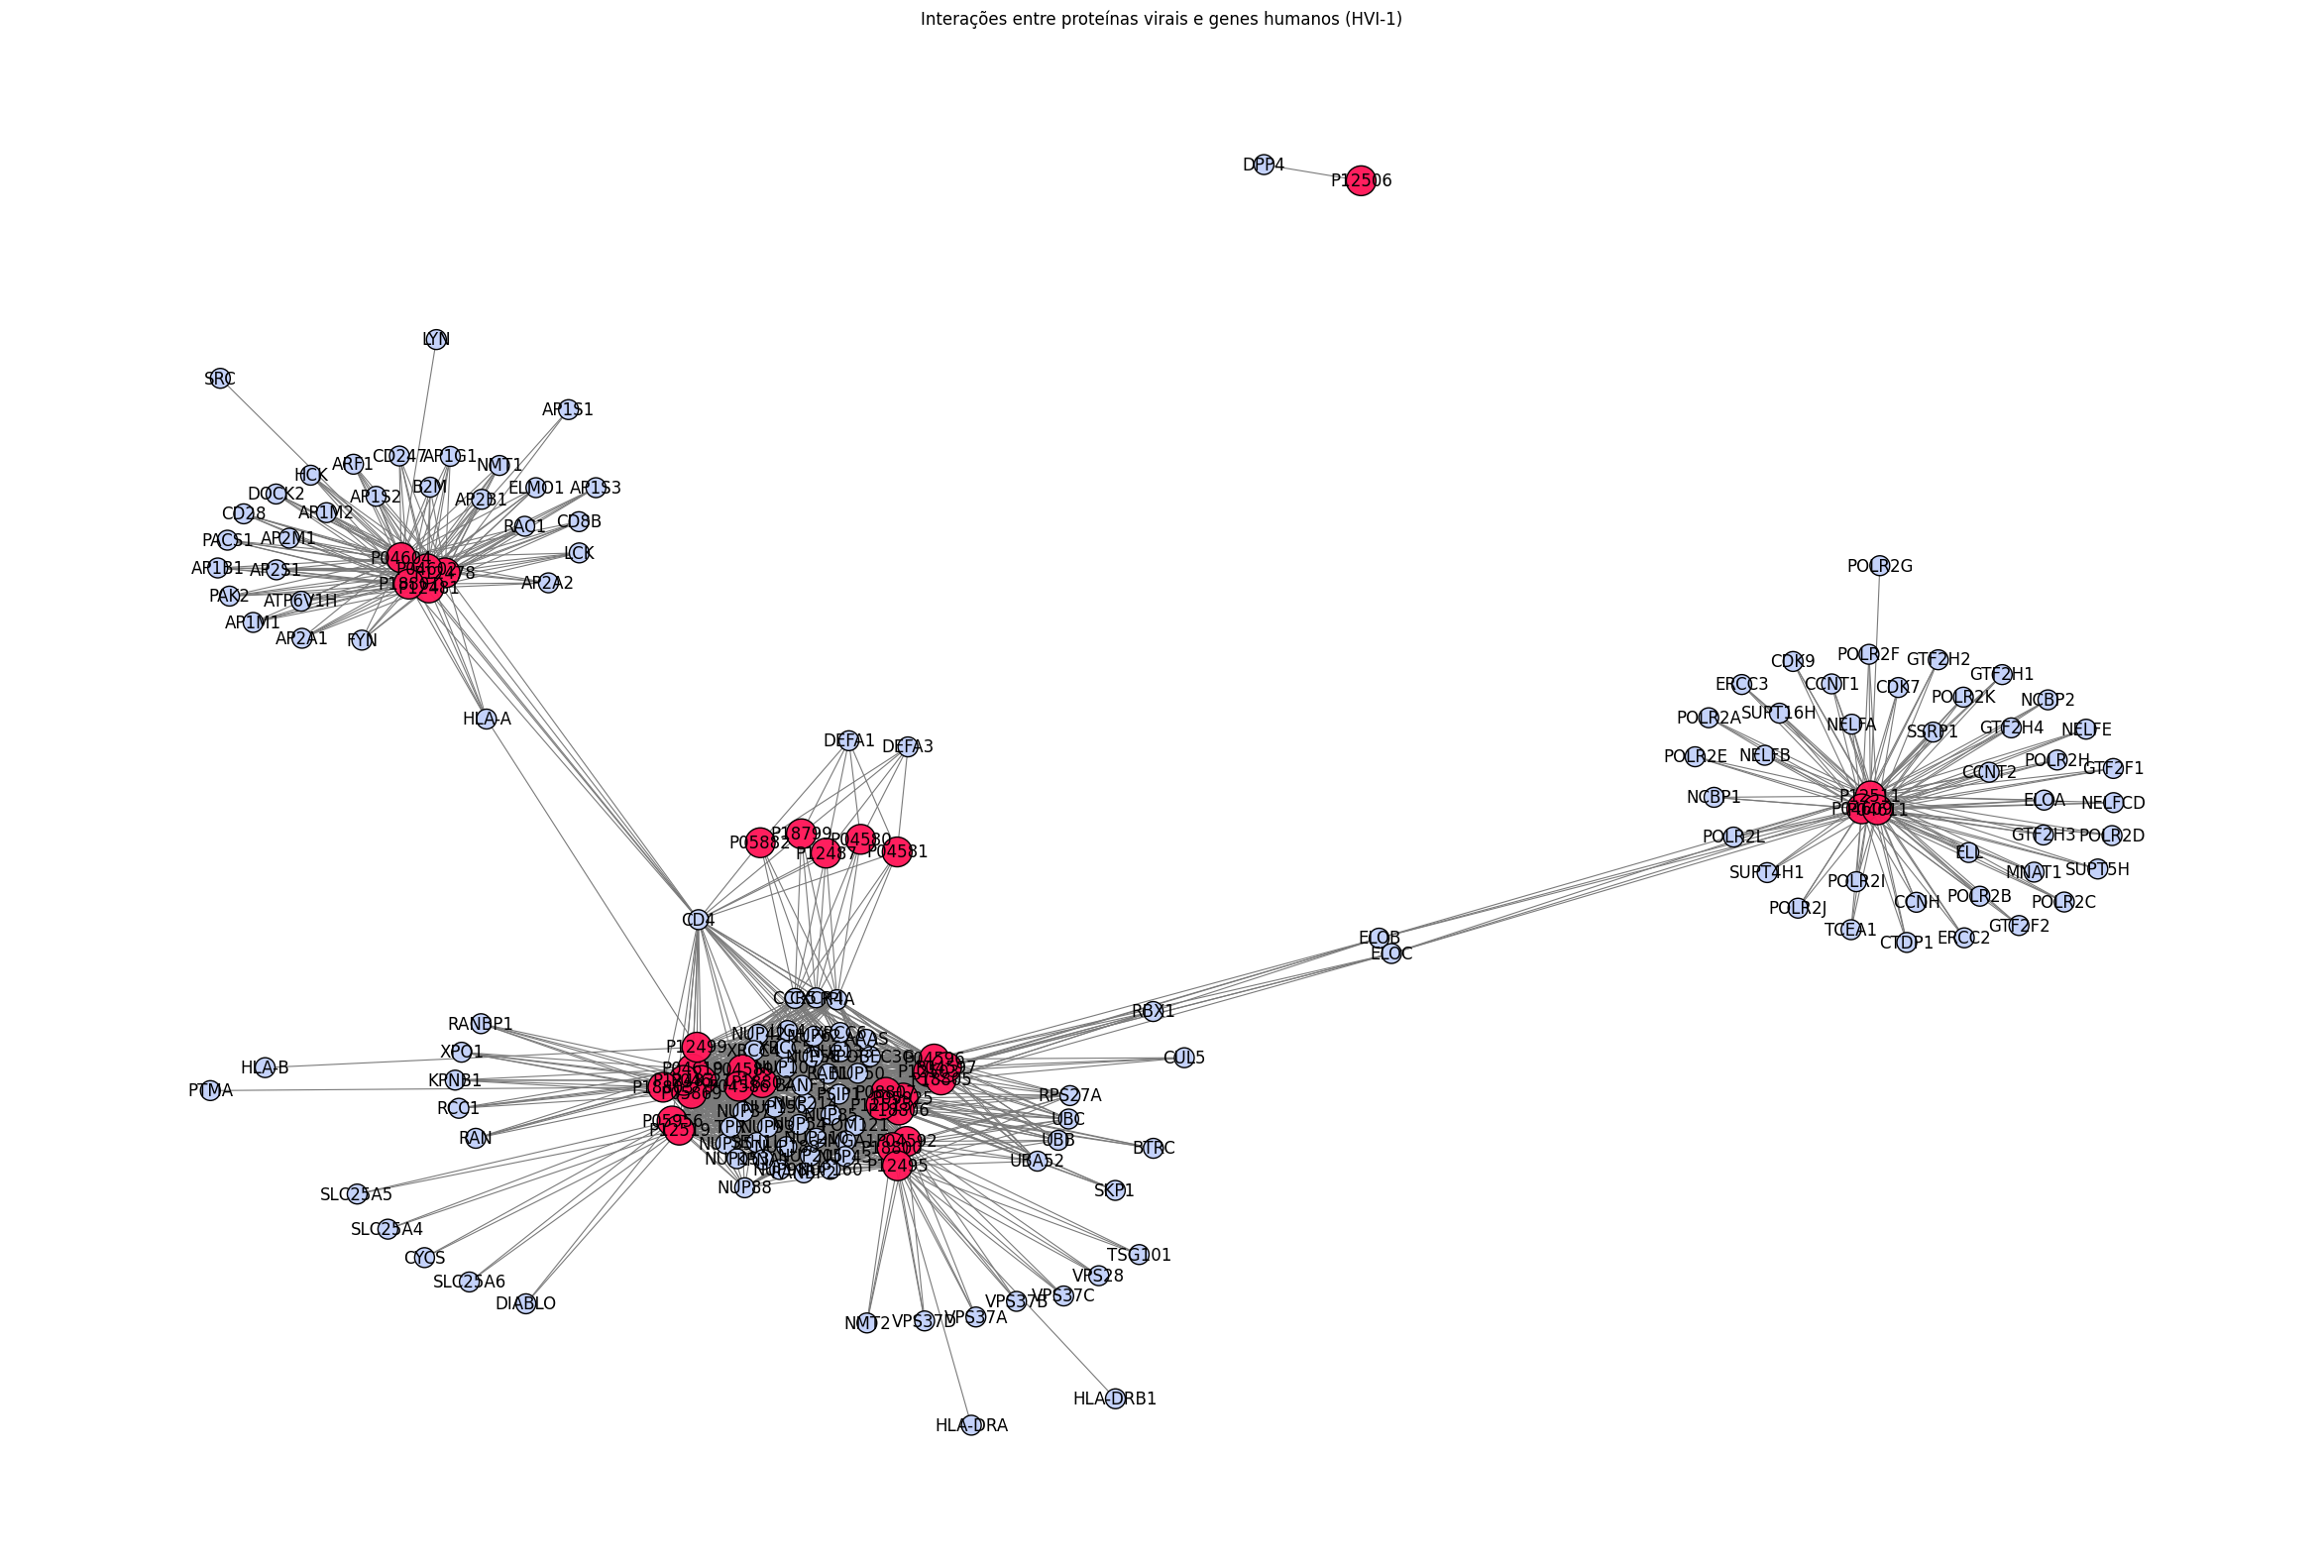

In [93]:
plot_gene_protein_graph(ppi_hiv1MD, 'Uniprot_virus', 'Human_GeneSymbol',
                        'Interações entre proteínas virais e genes humanos (HVI-1)',
                        30, 20)

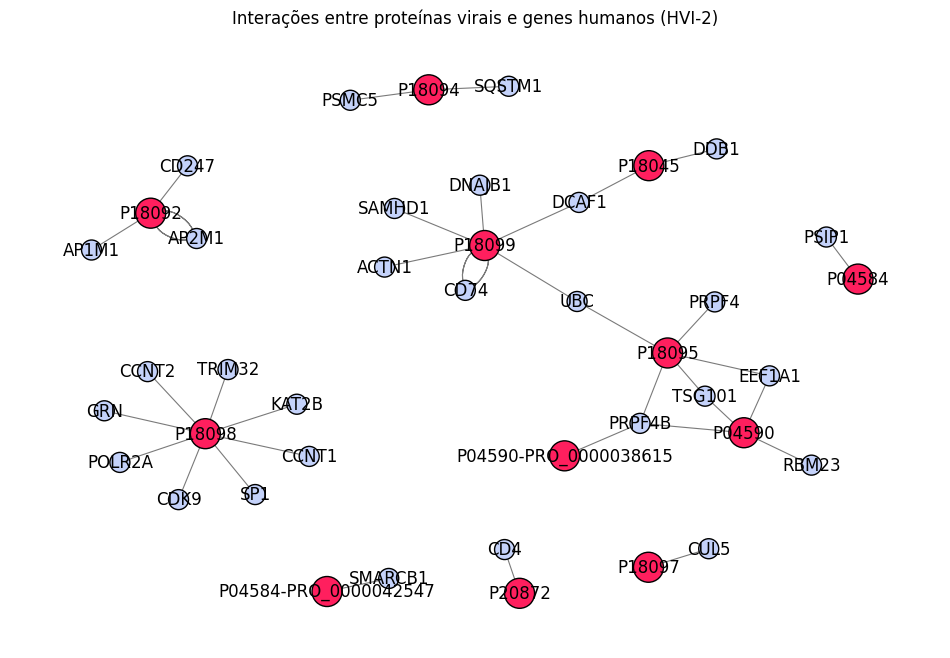

In [69]:
plot_gene_protein_graph(ppi_hiv2A, 'Uniprot_virus', 'Human_GeneSymbol',
                        'Interações entre proteínas virais e genes humanos (HVI-2)',
                        12, 8)

## 4.1 Interseção e significância de LCC

LCC (Largest Connected Component) é uma métrica que representa o maior componente conectado de um grafo, indicando, desse modo, o conjunto mais extenso de nós que estão interconectados.

A significância do tamanho de LCC pode ser cálculada a partir do Z-score:

$ Z_{Score \, LCC} = \frac{LCC - \mu_{LCC}}{\sigma_{LCC}} $

**Explicação da fórmula:**

- $Z_{Score \, LCC}$: Z-score do maior componente conectado;
- $LCC$: tamanho do maior componente;
- $\mu_{LCC}$: média dos componentes do LCC (aleatório);
- $\sigma_{LCC}$: desvio padrão dos tamanhos do LCC.

In [23]:
intersection_graph = nx.intersection(hiv1_graph, hiv2_graph)
intersection_graph.number_of_edges()

NameError: name 'nx' is not defined

### 4.1.1 HVI-1

In [ ]:
lcc_hiv1 = calculate_lcc(hiv1_graph)

In [ ]:
# gerando grafos aleatórios para comparação
num_graphs = 1000
num_nodes = len(hiv1_graph.nodes)
prob = 0.05  # probabilidade de conexão entre os nós
random_graphs = generate_random_graphs(num_graphs, num_nodes, prob)

lcc_randoms = [calculate_lcc(graph) for graph in random_graphs]

# média e desvio padrão dos LCCs aleatórios
mean_lcc_randoms = np.mean(lcc_randoms)
std_lcc_randoms = np.std(lcc_randoms)

In [ ]:
zscore_hiv1 = (lcc_hiv1 - mean_lcc_randoms) / std_lcc_randoms

In [ ]:
print(f"Tamanho do LCC para HIV-1: {lcc_hiv1}, Z-score: {zscore_hiv1:.2f}")

In [ ]:
plot_histogram(lcc_randoms, lcc_hiv1, 'Distribuição dos Tamanhos do LCC em Grafos Aleatórios (HVI-1)', f'LCC HVI-1: {lcc_hiv1}')

### HVI-2

In [ ]:
lcc_hiv2 = calculate_lcc(hiv2_graph)

In [ ]:
# gerando grafos aleatórios para comparação
num_graphs = 1000
num_nodes = len(hiv2_graph.nodes)
prob = 0.05  # probabilidade de conexão entre os nós
random_graphs = generate_random_graphs(num_graphs, num_nodes, prob)

lcc_randoms = [calculate_lcc(graph) for graph in random_graphs]

# média e desvio padrão dos LCCs aleatórios
mean_lcc_randoms = np.mean(lcc_randoms)
std_lcc_randoms = np.std(lcc_randoms)

In [ ]:
zscore_hiv2 = (lcc_hiv2 - mean_lcc_randoms) / std_lcc_randoms

In [ ]:
print(f"Tamanho do LCC para HIV-1: {lcc_hiv2}, Z-score: {lcc_hiv2:.2f}")

In [ ]:
plot_histogram(lcc_randoms, lcc_hiv2, 'Distribuição dos Tamanhos do LCC em Grafos Aleatórios (HVI-2)', f'LCC HVI-2: {lcc_hiv2}')